In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5,6'

import tensorflow as tf
tf.config.list_physical_devices('GPU')

2025-04-09 10:38:37.191171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744175317.209410 4007735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744175317.215005 4007735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744175317.228817 4007735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744175317.228834 4007735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744175317.228836 4007735 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU')]

In [2]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, set_seed
)
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

## Use the original variant 1 dataset without normalization 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-p

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.837300,1.570320,0.580714,0.315863
2,1.109200,1.192420,0.665714,0.400676
3,0.904900,1.046406,0.691429,0.443903
4,0.771000,0.973082,0.695714,0.445792
5,0.656300,0.957335,0.700000,0.490837
6,0.571400,0.896985,0.720000,0.528901
7,0.511600,0.874973,0.733571,0.582832
8,0.439700,0.864937,0.735714,0.584980
9,0.404600,0.854814,0.745714,0.603281
10,0.389900,0.841857,0.751429,0.612160


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 0.841857373714447, 'eval_micro_f1': 0.7514285714285714, 'eval_macro_f1': 0.6121597320509761, 'eval_runtime': 3.1957, 'eval_samples_per_second': 438.09, 'eval_steps_per_second': 10.952, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-p

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.826500,1.615784,0.542857,0.221849
2,1.298800,1.386953,0.608571,0.328895
3,1.106200,1.287892,0.625714,0.349071
4,1.007700,1.214224,0.641429,0.371521
5,0.915100,1.151087,0.655714,0.385293
6,0.816100,1.160966,0.653571,0.379678
7,0.803700,1.140331,0.660714,0.392392
8,0.701900,1.147023,0.666429,0.408594
9,0.678500,1.129550,0.665000,0.419780
10,0.644900,1.127599,0.672857,0.425530


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1275993585586548, 'eval_micro_f1': 0.6728571428571428, 'eval_macro_f1': 0.4255302636402597, 'eval_runtime': 3.1414, 'eval_samples_per_second': 445.662, 'eval_steps_per_second': 11.142, 'epoch': 10.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.846200,1.634292,0.538571,0.218954
2,1.314900,1.400945,0.606429,0.328578
3,1.120600,1.292474,0.627143,0.344522
4,1.028600,1.229996,0.637143,0.365277
5,0.925100,1.160173,0.651429,0.381254
6,0.835100,1.164770,0.647857,0.373640
7,0.820500,1.145563,0.661429,0.394566
8,0.712500,1.151214,0.657857,0.398216
9,0.689900,1.132809,0.660714,0.400390
10,0.655600,1.126203,0.662143,0.410084


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1262030601501465, 'eval_micro_f1': 0.6621428571428571, 'eval_macro_f1': 0.4100837818707975, 'eval_runtime': 3.0911, 'eval_samples_per_second': 452.92, 'eval_steps_per_second': 11.323, 'epoch': 10.0}


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum ver

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.623000,1.300349,0.651429,0.380361
2,0.958600,1.050791,0.688571,0.413571
3,0.827300,0.941083,0.701429,0.484831
4,0.710600,0.882396,0.724286,0.550545
5,0.574600,0.868482,0.736429,0.631828
6,0.490100,0.853483,0.748571,0.641977
7,0.446900,0.836767,0.756429,0.656118
8,0.376800,0.834904,0.761429,0.662673
9,0.345300,0.838462,0.757857,0.665856
10,0.313600,0.838191,0.758571,0.670720


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 0.8381912708282471, 'eval_micro_f1': 0.7585714285714286, 'eval_macro_f1': 0.6707201074680735, 'eval_runtime': 11.8256, 'eval_samples_per_second': 118.387, 'eval_steps_per_second': 2.96, 'epoch': 10.0}


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum ver

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.775100,1.552436,0.556429,0.254786
2,1.201700,1.361152,0.593571,0.329967
3,1.048100,1.300453,0.592857,0.333554
4,0.979000,1.227314,0.622143,0.382550
5,0.894800,1.184525,0.649286,0.420718
6,0.801800,1.177601,0.650000,0.417446
7,0.783700,1.161533,0.654286,0.426808
8,0.664100,1.161768,0.648571,0.451804
9,0.648200,1.153430,0.661429,0.466110
10,0.622500,1.155485,0.657143,0.463690


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1534301042556763, 'eval_micro_f1': 0.6614285714285715, 'eval_macro_f1': 0.4661100620466651, 'eval_runtime': 11.8951, 'eval_samples_per_second': 117.695, 'eval_steps_per_second': 2.942, 'epoch': 10.0}


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum ver

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.784300,1.597505,0.527143,0.216103
2,1.253600,1.396829,0.585714,0.323847
3,1.094300,1.332042,0.587143,0.327876
4,1.027500,1.249690,0.618571,0.358326
5,0.932500,1.209501,0.632857,0.399863
6,0.845800,1.197918,0.641429,0.429843
7,0.833400,1.193851,0.642143,0.445225
8,0.717700,1.191853,0.645714,0.454362
9,0.700600,1.190339,0.650000,0.460182
10,0.670400,1.183814,0.649286,0.461542


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1838144063949585, 'eval_micro_f1': 0.6492857142857142, 'eval_macro_f1': 0.4615415450803304, 'eval_runtime': 11.72, 'eval_samples_per_second': 119.454, 'eval_steps_per_second': 2.986, 'epoch': 10.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.780100,1.368544,0.645714,0.380068
2,0.977300,1.066051,0.682857,0.404738
3,0.814000,0.933393,0.710714,0.502358
4,0.702800,0.866042,0.725714,0.539018
5,0.580200,0.828508,0.753571,0.631284
6,0.493800,0.823366,0.761429,0.661224
7,0.456200,0.820578,0.763571,0.666195
8,0.387600,0.823474,0.765714,0.668190
9,0.356500,0.806606,0.764286,0.671644
10,0.325800,0.810106,0.766429,0.675726


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 0.8101062178611755, 'eval_micro_f1': 0.7664285714285715, 'eval_macro_f1': 0.6757262399541293, 'eval_runtime': 3.1435, 'eval_samples_per_second': 445.365, 'eval_steps_per_second': 11.134, 'epoch': 10.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version o

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.799100,1.540955,0.562143,0.257930
2,1.200100,1.377182,0.595714,0.327061
3,1.053200,1.301042,0.600714,0.334961
4,0.979500,1.224767,0.633571,0.377555
5,0.887200,1.183286,0.659286,0.417349
6,0.805600,1.190983,0.661429,0.430209
7,0.785500,1.189127,0.657857,0.429943
8,0.686100,1.189672,0.657143,0.435748
9,0.662900,1.180333,0.666429,0.458657
10,0.624100,1.177793,0.667143,0.453449


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1803330183029175, 'eval_micro_f1': 0.6664285714285715, 'eval_macro_f1': 0.4586572759756639, 'eval_runtime': 3.136, 'eval_samples_per_second': 446.431, 'eval_steps_per_second': 11.161, 'epoch': 10.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4007735/48292134.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.803400,1.547011,0.557857,0.248409
2,1.189600,1.373356,0.589286,0.320724
3,1.045600,1.313246,0.586429,0.334398
4,0.971400,1.233811,0.635714,0.410581
5,0.893000,1.187856,0.652143,0.428440
6,0.800100,1.201243,0.645000,0.431338
7,0.778700,1.187571,0.653571,0.436487
8,0.676200,1.191911,0.655714,0.448741
9,0.655400,1.186007,0.662857,0.454993
10,0.633600,1.185521,0.662143,0.465267


/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/srmist5/miniconda3/envs/tamil/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DEBUG: Evaluation Metrics: {'eval_loss': 1.1855206489562988, 'eval_micro_f1': 0.6621428571428571, 'eval_macro_f1': 0.4652670521736483, 'eval_runtime': 3.1124, 'eval_samples_per_second': 449.821, 'eval_steps_per_second': 11.246, 'epoch': 10.0}

🚀 Training TF-IDF + SVM on Original...

🚀 Training TF-IDF + SVM on TFIDF-SRT-Original...

🚀 Training TF-IDF + SVM on TFIDF-SRT-Normalized...

📋 Results Summary:

                                         Micro F1  Macro F1  \
legal_BERT (Original)                       75.14     61.22   
legal_BERT (TFIDF-SRT-Original)             67.29     42.55   
legal_BERT (TFIDF-SRT-Normalized)           66.21     41.01   
legal_longformer (Original)                 75.86     67.07   
legal_longformer (TFIDF-SRT-Original)       66.14     46.61   
legal_longformer (TFIDF-SRT-Normalized)     64.93     46.15   
legal_Roberta (Original)                    76.64     67.57   
legal_Roberta (TFIDF-SRT-Original)          66.64     45.87   
legal_Roberta (TFIDF-SRT-No

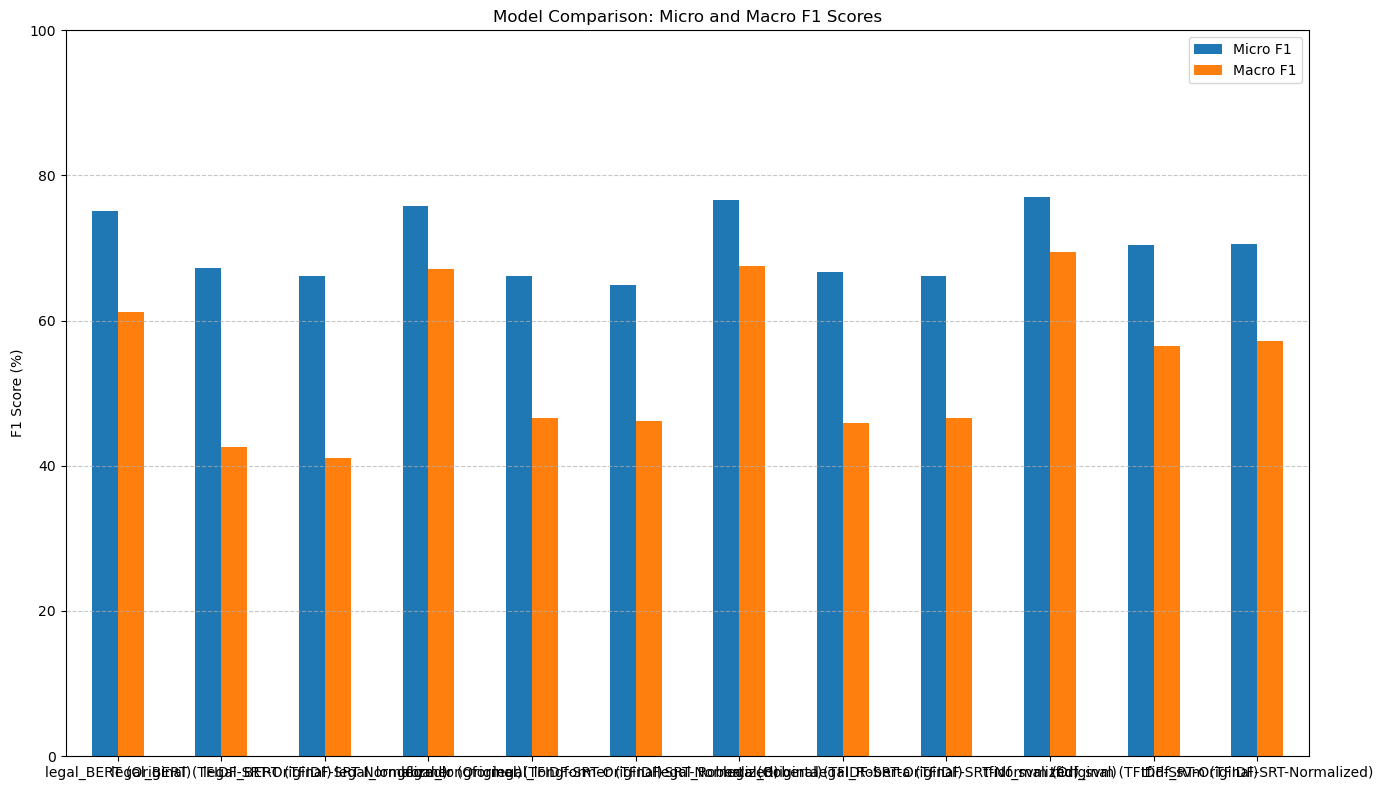

ModuleNotFoundError: No module named 'openpyxl'

In [18]:


# ----- Config -----
model_names = {
    "legal_BERT": "nlpaueb/legal-bert-base-uncased",
    "legal_longformer": "lexlms/legal-longformer-base",
    "legal_Roberta":"lexlms/legal-roberta-base"
}


learning_rate = 1e-5
epochs = 10
seed = 42

set_seed(seed)

# ----- Load Dataset -----
original_dataset=load_dataset("coastalcph/lex_glue", "scotus")
tfidf_srt_original_dataset = load_dataset("victorambrose11/lex_glue_original_TFIDF-SRT")
tfidf_srt_normalized_dataset = load_dataset("victorambrose11/lex_glue_normalized_TFIDF-SRT")

label_list = original_dataset["train"].features["label"].names
num_labels = len(label_list)

# ----- Token Classification Metric -----
def compute_f1(pred):
    import numpy as np
    from sklearn.metrics import f1_score

    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids

    return {
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
    }

results = {}

# ----- Training Function -----
def train_transformer_model(model_key, dataset, dataset_label):
    model_checkpoint = model_names[model_key]
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    # Preprocessing
    def preprocess(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    
    encoded_dataset = dataset.map(preprocess, batched=True)
    encoded_dataset = encoded_dataset.rename_column("label", "labels")
    encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    training_args = TrainingArguments(
        output_dir=f"./results_{model_key}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        seed=seed,
        logging_dir=f"./logs_{model_key}",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        compute_metrics=compute_f1,
        tokenizer=tokenizer,
    )

    trainer.train()

    metrics = trainer.evaluate()
    print(f"DEBUG: Evaluation Metrics: {metrics}")
    results[f"{model_key} ({dataset_label})"] = {
        "Micro F1": round(metrics.get("eval_micro_f1", 0.0) * 100, 2),
        "Macro F1": round(metrics.get("eval_macro_f1", 0.0) * 100, 2),
        "Dataset": dataset_label
    }
# ----- Train LegalBERT and LegalLongformer -----
original_dataset
tfidf_srt_original_dataset 
tfidf_srt_normalized_dataset

## legal bert on all three datasets 
train_transformer_model("legal_BERT", original_dataset, "Original")
train_transformer_model("legal_BERT", tfidf_srt_original_dataset, "TFIDF-SRT-Original")
train_transformer_model("legal_BERT", tfidf_srt_normalized_dataset, "TFIDF-SRT-Normalized")


## legal_longformer on all three datasets 
train_transformer_model("legal_longformer", original_dataset, "Original")
train_transformer_model("legal_longformer", tfidf_srt_original_dataset, "TFIDF-SRT-Original")
train_transformer_model("legal_longformer", tfidf_srt_normalized_dataset, "TFIDF-SRT-Normalized")


## legal_Roberta on all three datasets 

train_transformer_model("legal_Roberta", original_dataset, "Original")
train_transformer_model("legal_Roberta", tfidf_srt_original_dataset, "TFIDF-SRT-Original")
train_transformer_model("legal_Roberta", tfidf_srt_normalized_dataset, "TFIDF-SRT-Normalized")



# ----- Train TF-IDF + SVM -----
def train_svm(dataset, dataset_label=""):
    print(f"\n🚀 Training TF-IDF + SVM on {dataset_label}...")

    train_texts = dataset["train"]["text"]
    train_labels = dataset["train"]["label"]
    val_texts = dataset["validation"]["text"]
    val_labels = dataset["validation"]["label"]

    vectorizer = TfidfVectorizer(max_features=10000)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)

    clf = LinearSVC(max_iter=epochs * 100)  # Emulating epoch-based behavior
    clf.fit(X_train, train_labels)
    preds = clf.predict(X_val)

    model_name = f"tfidf_svm ({dataset_label})"
    results[model_name] = {
        "Micro F1": round(f1_score(val_labels, preds, average="micro") * 100, 2),
        "Macro F1": round(f1_score(val_labels, preds, average="macro") * 100, 2),
        "Dataset": dataset_label
    }

## SVM on all three datasets 

train_svm(original_dataset, "Original")
train_svm(tfidf_srt_original_dataset, "TFIDF-SRT-Original")
train_svm(tfidf_srt_normalized_dataset, "TFIDF-SRT-Normalized")


# ----- Print Table -----
results_df = pd.DataFrame.from_dict(results, orient="index")

print("\n📋 Results Summary:\n")
print(results_df)

# ----- Plot Chart -----
results_df.plot(kind="bar", figsize=(14, 8), ylim=(0, 100))
plt.title("Model Comparison: Micro and Macro F1 Scores")
plt.ylabel("F1 Score (%)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
results_df.to_excel('/home/srmist5/victor/BERT_Optimize/new_final/results_variant_1_performance.xlsx',index=False)

In [24]:
# !pip install openpyxl
results_df.to_excel('results_variant_1_performance.xlsx',index=False)